In this lab, you should try to implement some of the techniques discussed in the lecture.
Here is a list of reasonable tasks.

Must implement:
 * [OK] Log-loss
 
Easy:
 * [OK] L1 and L2 regularization (choose one)
 * [OK] momentum, Nesterov's momentum (choose one)

Medium difficulty:
 * [OK] Adagrad, RMSProp (choose one)
 * [OK] dropout

Hard (and a bit time-consuming to really figure out what you need to do):
 * batch-normalization
 * data augmentation (tiny rotatations, up/down-scalings etc.)

Try to test your network to see if these changes improve accuracy. They improve accuracy much more if you increase the layer size, and if you add more layers.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import timeit

In [3]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
mnist.train.labels.shape

(55000, 10)

In [6]:
mnist.train.images.shape
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f6ea4396e10>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f6ea4396c10>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f6e6cde7b10>)

In [7]:
class QuadraticCost(object):
    @staticmethod
    def delta(output_activations, y):
        return np.multiply(output_activations-y, np.multiply(output_activations, 1-output_activations))
    
class CrossEntropyCost(object):
    @staticmethod
    def delta(output_activations, y):
        return output_activations - y

In [8]:
class Momentum(object):
    
    def __init__(self, sizes):
        self.velocity = [np.zeros((y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
        self.m = 0.6
        
    def optimize(self, eta, grad):
        self.velocity = [self.m*v + eta*g for v, g in zip(self.velocity, grad)]
        return self.velocity

# class Nesterov(Momentum):
#     def optimize(self, eta, grad):
#         tmp_velocity = [m*v + eta*g for v, g in zip(self.velocity, grad)]
#         self.velocity = []
#         return self.velocity

class Adagrad(object):
    def __init__(self, sizes):
        self.G = [np.zeros((y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
        self.eps = 1e-8
        
    def optimize(self, eta, grad):
        self.G = [G + np.square(g) for g, G, in zip(grad, self.G)]
        return [np.divide(eta, np.sqrt(G + self.eps))*g for g, G in zip(grad, self.G)]

class RMSProp(object):
    def optimize(self, eta, grad):
        pass

In [9]:
class Network(object):
    def __init__(self, sizes, cost=QuadraticCost, regularization=None, dropout=0., optimization=None):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.dropout = 1 - dropout
        self.cost = cost
        self.regularization = regularization
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        if optimization == 'Nesterov':
            self.opt = Nesterov()
        elif optimization == 'momentum':
            self.opt = Momentum(self.sizes)
        elif optimization == 'Adagrad':
            self.opt = Adagrad(sizes)
        elif optimization == 'RMSProp':
            self.opt = RMSProp()
        else:
            self.opt = None
        
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a
    def update_mini_batch(self, mini_batch, eta, lmbda, n, m):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate      
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T) # CHANGE: Just one call!
        
        
        if self.opt is None:
            grad = [eta*nw for nw in nabla_w]
        else:        
            grad = self.opt.optimize(eta, nabla_w)
        
        self.weights = [self.regularize(w, eta, lmbda, n) - g/len(mini_batch[0]) 
                        for w, g in zip(self.weights, grad)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        print x.shape
        u = np.ones(x.shape)
        us = [u]
        gs = [g] # list to store all the gs, layer by layer
        for b, w in zip(self.biases, self.weights):
            g = sigmoid(np.dot(w, g*u)+b)
            u = np.random.binomial(1, self.dropout, size=g.shape) / self.dropout
            gs.append(g)
            us.append(u)
        
        # backward pass
        dLdf = self.cost.delta(gs[-1], y)
        dLdfs = [dLdf]
        for w,g,u in reversed(zip(self.weights[1:],gs[1:-1], us[1:-1])):
            dLdf = u*np.multiply(np.matmul(w.T, dLdf),np.multiply(g,1-g))
            dLdfs.append(dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])] # automatic here
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] # CHANGE: Need to sum here
    
        return (dLdBs,dLdWs)
    
    def regularize(self, w, eta, lmbda, n):
        if self.regularization is None:
            return w
        elif self.regularization is 'l1':
            return w - eta*(lmbda/n)*np.sign(w)
        elif self.regularization is 'l2':
            return (1 - eta*(lmbda/n))*w
        
    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return sum(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, lmbda=0.0, test_data=None, m=0.):
        train_size = training_data.images.shape[0]
        result = None
        if test_data:
            test_size = test_data.images.shape[0]
            result = []
        for j in xrange(epochs):
            t1 = timeit.default_timer()
            for k in range(train_size/mini_batch_size):
                self.update_mini_batch(training_data.next_batch(mini_batch_size), eta, lmbda, training_data.labels.shape[0], m)
            if test_data:
                res = np.mean([self.evaluate(test_data.next_batch(mini_batch_size)) for k in range(test_size/mini_batch_size)])/mini_batch_size
                t2 = timeit.default_timer()
                result.append(res)
                print "Epoch {0}: {1}  in {2}".format(j, res,t2-t1)
            else:
                print "Epoch {0} complete".format(j)
        return result

In [10]:
epochs = 30

# Base network
result_1 = Network([784,30,10]).SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,test_data=mnist.test)


(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)

(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
Epoch 2: 0.7576  in 0.594841003418
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 20

Epoch 5: 0.799  in 0.525411844254
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200

(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
Epoch 8: 0.8151  in 0.533431053162
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 200)
(784, 20

KeyboardInterrupt: 

In [23]:
# Easy tasks with small network

epochs = 30

# Base network
result_1 = Network([784,30,10]).SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,test_data=mnist.test)

# Network with logloss function
result_2 = Network([784,30,10], cost=CrossEntropyCost).SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,test_data=mnist.test)

# Network with logloss and L2
result_3 = Network([784,30,10], cost=CrossEntropyCost, regularization="l2").SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,lmbda=5.0,test_data=mnist.test)

# Network with logloss and L1
#result_4 = Network([784,30,10], cost=CrossEntropyCost, regularization="l1").SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,lmbda=3.0,test_data=mnist.test)

# Network with logloss, L2 and nesterov momentum
# result_5 = Network([784,30,10], cost=CrossEntropyCost, regularization="l2").SGD(mnist.train,epochs=epochs,mini_batch_size=200,eta=3.0,lmbda=5.0,test_data=mnist.test, m=0.2)


Epoch 0: 0.4886  in 0.478934049606
Epoch 1: 0.6659  in 0.446777105331
Epoch 2: 0.6987  in 0.464801073074
Epoch 3: 0.7775  in 0.597726821899
Epoch 4: 0.8056  in 0.501221179962
Epoch 5: 0.8521  in 0.447762966156
Epoch 6: 0.8678  in 0.457562923431
Epoch 7: 0.8771  in 0.442883014679
Epoch 8: 0.8852  in 0.448653936386
Epoch 9: 0.8887  in 0.452832937241
Epoch 10: 0.8954  in 0.444975852966
Epoch 11: 0.8977  in 0.446645021439
Epoch 12: 0.9021  in 0.455061912537
Epoch 13: 0.9047  in 0.442463874817
Epoch 14: 0.9073  in 0.445922851562
Epoch 15: 0.9087  in 0.452577114105
Epoch 16: 0.9098  in 0.444138050079
Epoch 17: 0.9123  in 0.444622039795
Epoch 18: 0.912  in 0.454205036163
Epoch 19: 0.9141  in 0.442034959793
Epoch 20: 0.9153  in 0.446588993073
Epoch 21: 0.9158  in 0.452307939529
Epoch 22: 0.9173  in 0.444467067719
Epoch 23: 0.918  in 0.442275047302
Epoch 24: 0.9177  in 0.455160140991
Epoch 25: 0.921  in 0.445625066757
Epoch 26: 0.9219  in 0.44797706604
Epoch 27: 0.9208  in 0.451208114624
Epoch 

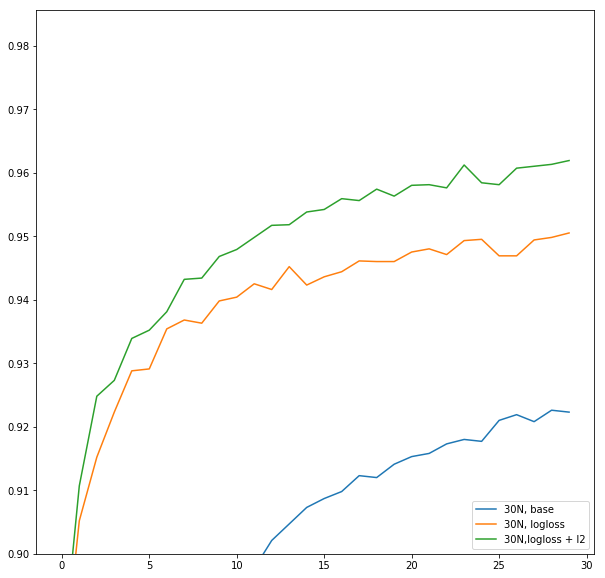

In [25]:
fig = plt.figure(figsize=(10, 10))
plt.plot(result_1, label="30N, base")
plt.plot(result_2, label="30N, logloss")
plt.plot(result_3, label="30N, logloss + l2")
plt.ylim(ymin=0.9)
plt.legend(loc=4)

In [41]:
# Gradient descent optimizations

epochs_2 = 50
# No optimization
result_2_1 = Network([784, 60, 10], cost=CrossEntropyCost, regularization="l2").SGD(mnist.train,epochs=epochs_2,mini_batch_size=200,eta=3.0,lmbda=5.0,test_data=mnist.test)

# Momentum
result_2_2 = Network([784, 60, 10], cost=CrossEntropyCost, regularization="l2", optimization='momentum').SGD(mnist.train,epochs=epochs_2,mini_batch_size=200,eta=3.0,lmbda=5.0,test_data=mnist.test)

# Adagrad
result_2_3 = Network([784, 60, 10], cost=CrossEntropyCost, regularization="l2", optimization='Adagrad').SGD(mnist.train,epochs=epochs_2,mini_batch_size=200,eta=3.0,lmbda=5.0,test_data=mnist.test)


Epoch 0: 0.8938  in 0.649582862854
Epoch 1: 0.9224  in 0.630646944046
Epoch 2: 0.9332  in 0.622627019882
Epoch 3: 0.9362  in 0.620394945145
Epoch 4: 0.9439  in 0.623679876328
Epoch 5: 0.9491  in 0.622366189957
Epoch 6: 0.9521  in 0.624860048294
Epoch 7: 0.9532  in 0.625926971436
Epoch 8: 0.9562  in 0.634210109711
Epoch 9: 0.9564  in 0.629632949829
Epoch 10: 0.9598  in 0.636875152588
Epoch 11: 0.9604  in 0.63847899437
Epoch 12: 0.9622  in 0.637804031372
Epoch 13: 0.9649  in 0.635650873184
Epoch 14: 0.9667  in 0.63845705986
Epoch 15: 0.966  in 0.637339830399
Epoch 16: 0.9689  in 0.645408153534
Epoch 17: 0.9684  in 0.641774892807
Epoch 18: 0.9659  in 0.648399114609
Epoch 19: 0.9697  in 0.646702051163
Epoch 20: 0.9716  in 0.645099878311
Epoch 21: 0.9711  in 0.641702890396
Epoch 22: 0.9718  in 0.650757074356
Epoch 23: 0.9704  in 0.647783041
Epoch 24: 0.9739  in 0.654199123383
Epoch 25: 0.9709  in 0.656638860703
Epoch 26: 0.9715  in 0.654321908951
Epoch 27: 0.9741  in 0.657273054123
Epoch 28

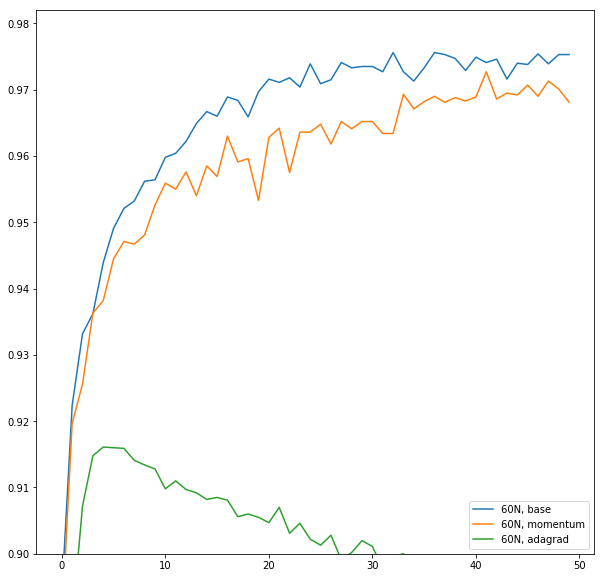

In [51]:
fig2 = plt.figure(figsize=(10, 10))
plt.plot(result_2_1, label="60N, base")
plt.plot(result_2_2, label="60N, momentum")
plt.plot(result_2_3, label="60N, adagrad")
plt.ylim(ymin=0.9)
plt.legend(loc=4)